In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from IPython.display import HTML
import datetime
import seaborn as sns

PROJ_PATH = '/home/anthony/personalSite/content/project/internet-traffic/'
pd.set_option('max_colwidth', 1000)

%run ./ping_helps.ipynb
%run ./graph_helps.ipynb

clean = read_all()

clean['hour'] = clean['tstamp'].apply(lambda x: x.hour)
clean['day'] =  clean['tstamp'].apply(lambda x: x.isoweekday())  
clean['date'] = clean['tstamp'].apply(lambda x: pd.to_datetime(x).date())

#clean[clean['lat'] > 6000] # Investigate those 3 outliers

TICK_SIZE = 10
LAB_SIZE = 15
TITLE_SIZE = 20

DOW_MAP = {1:'Monday',
           2:'Tuesday',
           3:'Wednesday',
           4:'Thursday',
           5:'Friday',
           6:'Saturday',
           7:'Sunday'
}

In [330]:
clean.nsmallest(1000, 'lat').groupby('hour')['date'].value_counts()

hour  date      
10    2020-06-30    600
11    2020-06-30    222
13    2020-06-29    178
Name: date, dtype: int64

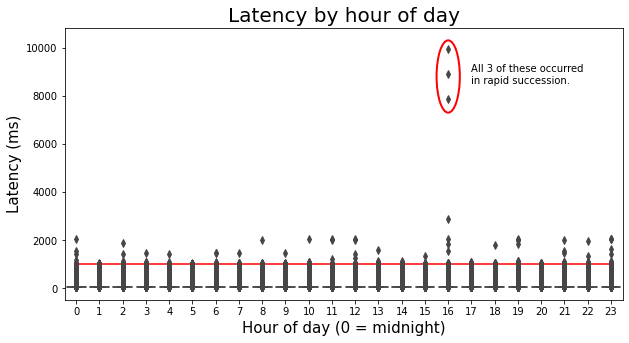

In [290]:
from matplotlib.patches import Ellipse
sns.boxplot(x='hour', y='lat', data=clean);
plt.gcf().set_figheight(5)
plt.gcf().set_figwidth(10)

ax = plt.gca();
ellipse = Ellipse(xy=(16, 8800), width=1, height=3000, 
                        edgecolor='r', fc='None', lw=2)
ax.add_patch(ellipse);

plt.annotate('All 3 of these occurred \nin rapid succession.', xy=(17, 8500))
plt.xlabel('Hour of day (0 = midnight)', fontsize=LAB_SIZE)
plt.ylabel('Latency (ms)', fontsize=LAB_SIZE)

plt.title('Latency by hour of day', fontsize=TITLE_SIZE)
plt.hlines(1000, 0, 23, color='red')
plt.savefig(PROJ_PATH+'yikes2.png')

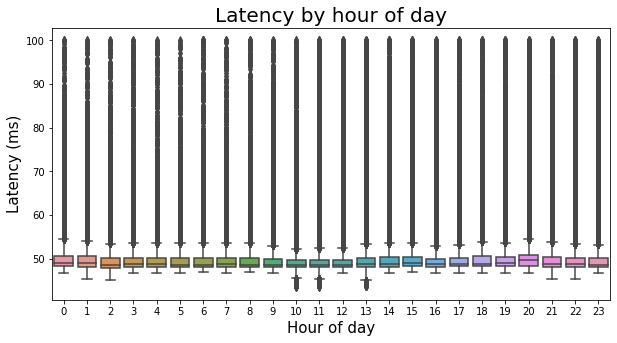

In [314]:
sns.boxplot(x='hour', y='lat', data=clean[clean['lat'] <= 100]);
plt.gcf().set_figheight(5)
plt.gcf().set_figwidth(10)
plt.xlabel('Hour of day', fontsize=LAB_SIZE)
plt.ylabel('Latency (ms)', fontsize=LAB_SIZE)
plt.title('Latency by hour of day', fontsize=TITLE_SIZE);
plt.savefig(PROJ_PATH+'fix.png')

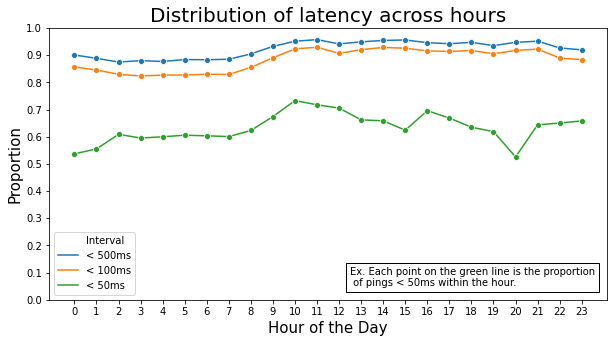

In [332]:
%run ./graph_helps.ipynb

a = bucket_dist('hour', 
                'lat', 
                np.arange(0, 1100, 500), 
                pd.Interval(-.001, 500), 
                label='< 500ms', df=clean)

b = bucket_dist('hour', 
                'lat', 
                np.arange(0, 1100, 100), 
                pd.Interval(-.001, 100), 
                label='< 100ms', df=clean)

c = bucket_dist('hour', 
                'lat', 
                np.arange(0, 1100, 50), 
                pd.Interval(-.001, 50), 
                label='< 50ms', df=clean)

# Create the plot
(
    pd.concat([a, b, c]).reset_index()
    .pipe(lambda df: sns.lineplot(x='hour', y='lat', hue='Interval', data = df, marker="o"))
)

plt.xlabel('Hour of the Day', fontsize=LAB_SIZE);
plt.xticks(np.arange(24));

plt.ylim((0, 1));
plt.yticks(np.arange(0, 1.1, .1));
plt.ylabel('Proportion', fontsize=LAB_SIZE)
plt.title('Distribution of latency across hours', fontsize=TITLE_SIZE)

helps = 'Ex. Each point on the green line is the proportion\n of pings < 50ms within the hour.'
plt.text(12.5, .05, helps, bbox=dict(fill=False))

plt.gcf().set_figheight(5);
plt.gcf().set_figwidth(10);
plt.savefig(PROJ_PATH+'both.png')

What do the observations that are "slow" have in common?

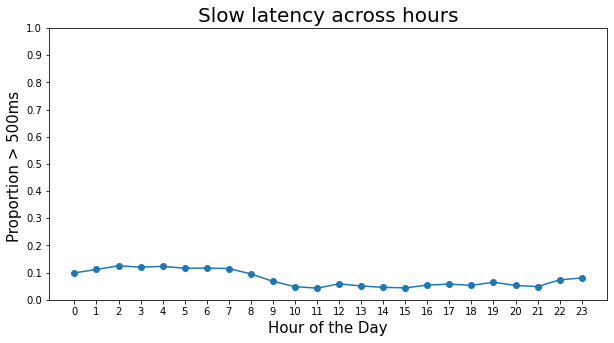

In [334]:
(
    clean.groupby('hour')['lat']
    .value_counts(bins=[0, 500, 10_000], normalize=True)
    [:, pd.Interval(500, 10_000)]
    .sort_index().plot(marker='o')
)
plt.gcf().set_figheight(5);
plt.gcf().set_figwidth(10);

plt.xlabel('Hour of the Day', fontsize=LAB_SIZE);
plt.xticks(np.arange(24));

plt.ylim((0, 1));
plt.yticks(np.arange(0, 1.1, .1));
plt.ylabel('Proportion > 500ms ', fontsize=LAB_SIZE)
plt.title('Slow latency across hours', fontsize=TITLE_SIZE)

plt.savefig(PROJ_PATH+'slows.png')

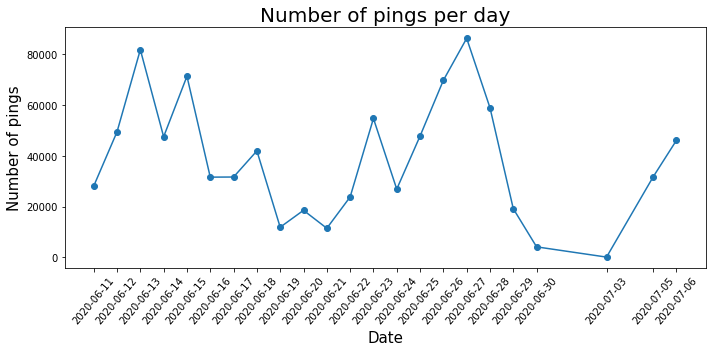

In [284]:
x = clean['date'].value_counts().to_frame('counts')
x['prop'] = x['counts'] / x['counts'].sum()
x['counts'].sort_index().plot(marker='o');

plt.title('Number of pings per day', fontsize=TITLE_SIZE)

plt.xlabel('Date', fontsize=LAB_SIZE);
plt.ylabel('Number of pings', fontsize=LAB_SIZE);

plt.xticks(x.index, rotation=50)

plt.gcf().set_figheight(5)
plt.gcf().set_figwidth(10)

plt.tight_layout() # Make room for the axis label
plt.savefig(PROJ_PATH+'sampsize.png')